This notebook is part of the deepcell-tf documentation: https://deepcell.readthedocs.io/.

# Training a cell tracking model

Implementation of: [Accurate cell tracking and lineage construction in live-cell imaging experiments with deep learning](https://www.biorxiv.org/content/10.1101/803205v2)


In [1]:
import os
import deepcell

import tensorflow as tf
import numpy as np

## Set up file path constants

In [2]:
import errno

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume

MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
OUTPUT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'nuc_tracking'))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR, OUTPUT_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Load the data

### Download data from deepcell.datasets

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models. All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed`, which is used to generate the random train-test split. Metadata associated with the dataset can be accessed through the `metadata` attribute.

Tracked data are stored as `.trks` files. These files include images and lineage data in np.arrays. To manipulate `.trks` files, use `deepcell.utils.tracking_utils.load_trks` and `deepcell.utils.tracking_utils.save_trks`.

In [ ]:
# Download sample tracking data (saves to ~/.keras/datasets)
filename = 'sample_tracking.trks'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracking.load_tracked_data(filename)

In [7]:
# Load and view stats on this file
from deepcell.utils.tracking_utils import trks_stats, load_trks

path = os.path.join(DATA_DIR, filename)
trks_stats(path)
trks_data = load_trks(path)

Dataset Statistics: 
Image data shape:  (722, 40, 216, 256, 1)
Number of lineages (should equal batch size):  722
Total number of unique tracks (cells)      -  11393
Total number of divisions                  -  855
Average cell density (cells/100 sq pixels) -  0.01694895003751154
Average number of frames per track         -  25


## Prepare the data

To facilitate training, we transform each movie's image and lineage data into a `Track` object.
`Tracks` help to encapsulate all of the feature creation from the movie, including:

* Appearances: `(num_frames, num_objects, 32, 32, 1)`
* Morphologies: `(num_frames, num_objects, 32, 32, 3)`
* Centroids: `(num_frames, num_objects, 2)`
* Normalized Adjacency Matrix: `(num_frames, num_objects, num_objects, 3)`
* Temporal Adjacency Matrix (comparing across frames): `(num_frames - 1, num_objects, num_objects, 3)`

All `Track` objects are then concatenated with each other (using `concat_tracks`) resulting in a single array for each feature.

In [10]:
%%time

from deepcell_tracking.utils import Track

all_tracks = Track(tracked_data=trks_data)

CPU times: user 6min 10s, sys: 5.4 s, total: 6min 15s
Wall time: 6min 15s


In [11]:
%%time

from deepcell_tracking.utils import concat_tracks

track_info = concat_tracks([all_tracks])
for k, v in track_info.items():
    print(k, v.shape)

appearances (688, 40, 39, 32, 32, 1)
centroids (688, 40, 39, 2)
morphologies (688, 40, 39, 3)
adj_matrices (688, 40, 39, 39)
norm_adj_matrices (688, 40, 39, 39)
temporal_adj_matrices (688, 39, 39, 39, 3)
CPU times: user 1.69 s, sys: 2.06 s, total: 3.75 s
Wall time: 3.75 s


## Set up training parameters

In [12]:
seed = 1   # Random seed for training/validation data split
batch_size = 4
track_length = 8  # only train on 8 frames at once
test_size = .20  # % of data saved as validation
n_epochs = 20     # Number of training epochs

steps_per_epoch = 512
validation_steps = 100

# find maximum number of cells in any frame
max_cells = track_info['appearances'].shape[2]

model_name = 'graph_tracking_model_seed{}'.format(seed)
model_path = os.path.join(MODEL_DIR, model_name)

## Create Tracking Dataset object

We then assemble `Tracks` as specified into a Tracking `Dataset` that is used during training

In [13]:
from deepcell.data.tracking import prepare_dataset


train_data, val_data, test_data = prepare_dataset(track_info,
                                                  rotation_range=0, 
                                                  translation_range=0,
                                                  seed=seed,
                                                  batch_size=batch_size,
                                                  track_length=track_length)

## Instantiate and Compile the Model
The goal is to predict the adjacency matrix and daughter adjacency matrix by attending over the edges provided by the spatiotemporal adjacency matrix (SAM). The SAM is constructed by linking cells that are in temporal or spatial proximity.

In [15]:
from deepcell.model_zoo.tracking import GNNTrackingModel

tm = GNNTrackingModel(max_cells=max_cells, n_layers=1)  # n_layers = number of graph convolutions

Before a model can be trained, it must be compiled with the chosen optimizer, loss function, and metrics.

This model uses padded data which must be flattened and filtered out before calling our metrics and loss.

In [16]:
def filter_and_flatten(y_true, y_pred):
    n_classes = tf.shape(y_true)[-1]
    new_shape = [-1, n_classes]
    y_true = tf.reshape(y_true, new_shape)
    y_pred = tf.reshape(y_pred, new_shape)

    # Mask out the padded cells
    good_loc = tf.where(y_true[:, 0] != -1)[:, 0]

    y_true = tf.gather(y_true, good_loc, axis=0)
    y_pred = tf.gather(y_pred, good_loc, axis=0)
    return y_true, y_pred


class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = filter_and_flatten(y_true, y_pred)
        super(Recall, self).update_state(y_true, y_pred, sample_weight)


class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = filter_and_flatten(y_true, y_pred)
        super(Precision, self).update_state(y_true, y_pred, sample_weight)


def loss_function(y_true, y_pred):
    y_true, y_pred = filter_and_flatten(y_true, y_pred)
    return deepcell.losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=tf.shape(y_true)[-1],
        axis=1)

In [17]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam

from deepcell import train_utils
from deepcell.losses import wce_for_adj_mat

# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)

# Define the loss function
losses = {'temporal_adj_matrices': loss_function}

# Define metrics
metrics = [
    Recall(class_id=0, name='same_recall'),
    Recall(class_id=1, name='different_recall'),
    Recall(class_id=2, name='daughter_recall'),
    Precision(class_id=0, name='same_precision'),
    Precision(class_id=1, name='different_precision'),
    Precision(class_id=2, name='daughter_precision'),
]

In [18]:
# Compile model
tm.training_model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

## Train Model and Verify Performance

Call fit on the compiled model, along with a defined set of callbacks.

In [19]:
# Verify GPU count
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Train the model
train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = tm.training_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

Training on 1 GPUs
Epoch 1/30
512/512 [==============================] - 89s 127ms/step - loss: 0.6358 - same_recall: 0.9086 - different_recall: 0.6182 - daughter_recall: 0.4560 - same_precision: 0.2294 - different_precision: 0.9927 - daughter_precision: 0.0019 - val_loss: 0.2600 - val_same_recall: 0.9991 - val_different_recall: 0.9940 - val_daughter_recall: 0.3152 - val_same_precision: 0.8718 - val_different_precision: 1.0000 - val_daughter_precision: 0.2661

Epoch 00001: val_loss improved from inf to 0.25998, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 2/30
512/512 [==============================] - 63s 122ms/step - loss: 0.1846 - same_recall: 0.9894 - different_recall: 0.9893 - daughter_recall: 0.5773 - same_precision: 0.8945 - different_precision: 0.9999 - daughter_precision: 0.0289 - val_loss: 0.0868 - val_same_recall: 0.9941 - val_different_recall: 0.9955 - val_daughter_recall: 0.8125 - val_same_precision: 0.9267 - val_different_precision: 1.0000 - val_daughter_precision: 0.1021

Epoch 00002: val_loss improved from 0.25998 to 0.08683, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 3/30
512/512 [==============================] - 62s 121ms/step - loss: 0.1320 - same_recall: 0.9920 - different_recall: 0.9951 - daughter_recall: 0.7642 - same_precision: 0.9461 - different_precision: 1.0000 - daughter_precision: 0.0622 - val_loss: 0.0739 - val_same_recall: 0.9951 - val_different_recall: 0.9991 - val_daughter_recall: 0.8176 - val_same_precision: 0.9909 - val_different_precision: 1.0000 - val_daughter_precision: 0.2238

Epoch 00003: val_loss improved from 0.08683 to 0.07390, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 4/30
512/512 [==============================] - 63s 122ms/step - loss: 0.1356 - same_recall: 0.9942 - different_recall: 0.9976 - daughter_recall: 0.7075 - same_precision: 0.9638 - different_precision: 0.9999 - daughter_precision: 0.1113 - val_loss: 0.0788 - val_same_recall: 0.9758 - val_different_recall: 0.9997 - val_daughter_recall: 0.8482 - val_same_precision: 0.9987 - val_different_precision: 0.9999 - val_daughter_precision: 0.1700

Epoch 00004: val_loss did not improve from 0.07390
Epoch 5/30
512/512 [==============================] - 62s 121ms/step - loss: 0.1127 - same_recall: 0.9943 - different_recall: 0.9984 - daughter_recall: 0.8115 - same_precision: 0.9774 - different_precision: 0.9999 - daughter_precision: 0.1785 - val_loss: 0.0594 - val_same_recall: 0.9980 - val_different_recall: 0.9993 - val_daughter_recall: 0.8444 - val_same_precision: 0.9876 - val_different_precision: 1.0000 - val_daughter_precision: 0.3918

Epoch 00005: val_loss improved from 0.07390 to 0.05936, s

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 6/30
512/512 [==============================] - 62s 121ms/step - loss: 0.1460 - same_recall: 0.9956 - different_recall: 0.9988 - daughter_recall: 0.7357 - same_precision: 0.9801 - different_precision: 0.9999 - daughter_precision: 0.2225 - val_loss: 0.1861 - val_same_recall: 0.9970 - val_different_recall: 0.9998 - val_daughter_recall: 0.5443 - val_same_precision: 0.9942 - val_different_precision: 0.9999 - val_daughter_precision: 0.9053

Epoch 00006: val_loss did not improve from 0.05936
Epoch 7/30
512/512 [==============================] - 63s 122ms/step - loss: 0.1301 - same_recall: 0.9964 - different_recall: 0.9990 - daughter_recall: 0.7333 - same_precision: 0.9805 - different_precision: 0.9999 - daughter_precision: 0.2545 - val_loss: 0.2431 - val_same_recall: 0.9968 - val_different_recall: 0.9999 - val_daughter_recall: 0.2951 - val_same_precision: 0.9948 - val_different_precision: 0.9999 - val_daughter_precision: 0.8571

Epoch 00007: val_loss did not improve from 0.05936
Epoch 

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 10/30
512/512 [==============================] - 62s 121ms/step - loss: 0.1083 - same_recall: 0.9972 - different_recall: 0.9995 - daughter_recall: 0.8074 - same_precision: 0.9892 - different_precision: 1.0000 - daughter_precision: 0.4636 - val_loss: 0.0484 - val_same_recall: 0.9968 - val_different_recall: 0.9993 - val_daughter_recall: 0.9359 - val_same_precision: 0.9945 - val_different_precision: 1.0000 - val_daughter_precision: 0.2522

Epoch 00010: val_loss improved from 0.05324 to 0.04845, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 11/30
512/512 [==============================] - 62s 122ms/step - loss: 0.0678 - same_recall: 0.9973 - different_recall: 0.9993 - daughter_recall: 0.8777 - same_precision: 0.9886 - different_precision: 0.9999 - daughter_precision: 0.4472 - val_loss: 0.0481 - val_same_recall: 0.9938 - val_different_recall: 0.9998 - val_daughter_recall: 0.9136 - val_same_precision: 0.9966 - val_different_precision: 0.9999 - val_daughter_precision: 0.5086

Epoch 00011: val_loss improved from 0.04845 to 0.04815, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 12/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0812 - same_recall: 0.9975 - different_recall: 0.9995 - daughter_recall: 0.8453 - same_precision: 0.9879 - different_precision: 0.9999 - daughter_precision: 0.4893 - val_loss: 0.0508 - val_same_recall: 0.9971 - val_different_recall: 0.9998 - val_daughter_recall: 0.8750 - val_same_precision: 0.9973 - val_different_precision: 1.0000 - val_daughter_precision: 0.5147

Epoch 00012: val_loss did not improve from 0.04815
Epoch 13/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0746 - same_recall: 0.9978 - different_recall: 0.9995 - daughter_recall: 0.8740 - same_precision: 0.9911 - different_precision: 1.0000 - daughter_precision: 0.4651 - val_loss: 0.0431 - val_same_recall: 0.9974 - val_different_recall: 0.9996 - val_daughter_recall: 0.9130 - val_same_precision: 0.9959 - val_different_precision: 1.0000 - val_daughter_precision: 0.3987

Epoch 00013: val_loss improved from 0.04815 to 0.04308,

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 14/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0592 - same_recall: 0.9978 - different_recall: 0.9996 - daughter_recall: 0.8544 - same_precision: 0.9920 - different_precision: 1.0000 - daughter_precision: 0.5756 - val_loss: 0.0157 - val_same_recall: 0.9949 - val_different_recall: 0.9992 - val_daughter_recall: 0.9704 - val_same_precision: 0.9921 - val_different_precision: 1.0000 - val_daughter_precision: 0.2855

Epoch 00014: val_loss improved from 0.04308 to 0.01573, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 15/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0747 - same_recall: 0.9973 - different_recall: 0.9996 - daughter_recall: 0.8700 - same_precision: 0.9928 - different_precision: 0.9999 - daughter_precision: 0.4944 - val_loss: 0.0767 - val_same_recall: 0.9965 - val_different_recall: 0.9999 - val_daughter_recall: 0.8785 - val_same_precision: 0.9969 - val_different_precision: 0.9999 - val_daughter_precision: 0.6709

Epoch 00015: val_loss did not improve from 0.01573
Epoch 16/30
512/512 [==============================] - 62s 120ms/step - loss: 0.1083 - same_recall: 0.9976 - different_recall: 0.9996 - daughter_recall: 0.8484 - same_precision: 0.9902 - different_precision: 1.0000 - daughter_precision: 0.5231 - val_loss: 0.0819 - val_same_recall: 0.9985 - val_different_recall: 0.9998 - val_daughter_recall: 0.8585 - val_same_precision: 0.9934 - val_different_precision: 1.0000 - val_daughter_precision: 0.7788

Epoch 00016: val_loss did not improve from 0.01573
Epoc

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 20/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0690 - same_recall: 0.9978 - different_recall: 0.9996 - daughter_recall: 0.9112 - same_precision: 0.9918 - different_precision: 1.0000 - daughter_precision: 0.6406 - val_loss: 0.0083 - val_same_recall: 0.9952 - val_different_recall: 0.9998 - val_daughter_recall: 0.9859 - val_same_precision: 0.9984 - val_different_precision: 0.9999 - val_daughter_precision: 0.4502

Epoch 00020: val_loss improved from 0.01525 to 0.00827, saving model to /data/models/graph_tracking_model_seed1


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 21/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0677 - same_recall: 0.9983 - different_recall: 0.9996 - daughter_recall: 0.9088 - same_precision: 0.9921 - different_precision: 1.0000 - daughter_precision: 0.5652 - val_loss: 0.0088 - val_same_recall: 0.9968 - val_different_recall: 0.9999 - val_daughter_recall: 0.9812 - val_same_precision: 0.9974 - val_different_precision: 0.9999 - val_daughter_precision: 0.7302

Epoch 00021: val_loss did not improve from 0.00827
Epoch 22/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0656 - same_recall: 0.9983 - different_recall: 0.9997 - daughter_recall: 0.9050 - same_precision: 0.9942 - different_precision: 1.0000 - daughter_precision: 0.6380 - val_loss: 0.0082 - val_same_recall: 0.9971 - val_different_recall: 0.9999 - val_daughter_recall: 0.9830 - val_same_precision: 0.9970 - val_different_precision: 1.0000 - val_daughter_precision: 0.7149

Epoch 00022: val_loss improved from 0.00827 to 0.00823,

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 23/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0578 - same_recall: 0.9984 - different_recall: 0.9997 - daughter_recall: 0.8947 - same_precision: 0.9934 - different_precision: 1.0000 - daughter_precision: 0.6820 - val_loss: 0.0083 - val_same_recall: 0.9973 - val_different_recall: 0.9999 - val_daughter_recall: 0.9843 - val_same_precision: 0.9986 - val_different_precision: 1.0000 - val_daughter_precision: 0.6510

Epoch 00023: val_loss did not improve from 0.00823

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0520 - same_recall: 0.9985 - different_recall: 0.9997 - daughter_recall: 0.9038 - same_precision: 0.9931 - different_precision: 1.0000 - daughter_precision: 0.6905 - val_loss: 0.0269 - val_same_recall: 0.9976 - val_different_recall: 0.9999 - val_daughter_recall: 0.9281 - val_same_precision: 0.9983 - val_different_precision: 1.0000 - val_da

INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


INFO:tensorflow:Assets written to: /data/models/graph_tracking_model_seed1/assets


Epoch 28/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0265 - same_recall: 0.9987 - different_recall: 0.9998 - daughter_recall: 0.9476 - same_precision: 0.9945 - different_precision: 1.0000 - daughter_precision: 0.8084 - val_loss: 0.0196 - val_same_recall: 0.9973 - val_different_recall: 0.9999 - val_daughter_recall: 0.9720 - val_same_precision: 0.9987 - val_different_precision: 1.0000 - val_daughter_precision: 0.6683

Epoch 00028: val_loss did not improve from 0.00596
Epoch 29/30
512/512 [==============================] - 62s 121ms/step - loss: 0.0409 - same_recall: 0.9984 - different_recall: 0.9998 - daughter_recall: 0.9495 - same_precision: 0.9952 - different_precision: 1.0000 - daughter_precision: 0.7652 - val_loss: 0.0259 - val_same_recall: 0.9966 - val_different_recall: 0.9999 - val_daughter_recall: 0.9541 - val_same_precision: 0.9981 - val_different_precision: 0.9999 - val_daughter_precision: 0.6800

Epoch 00029: val_loss did not improve from 0.00596
Epoc

Visualize the performance of the model by comparing the predicted classes of i frames in j movies

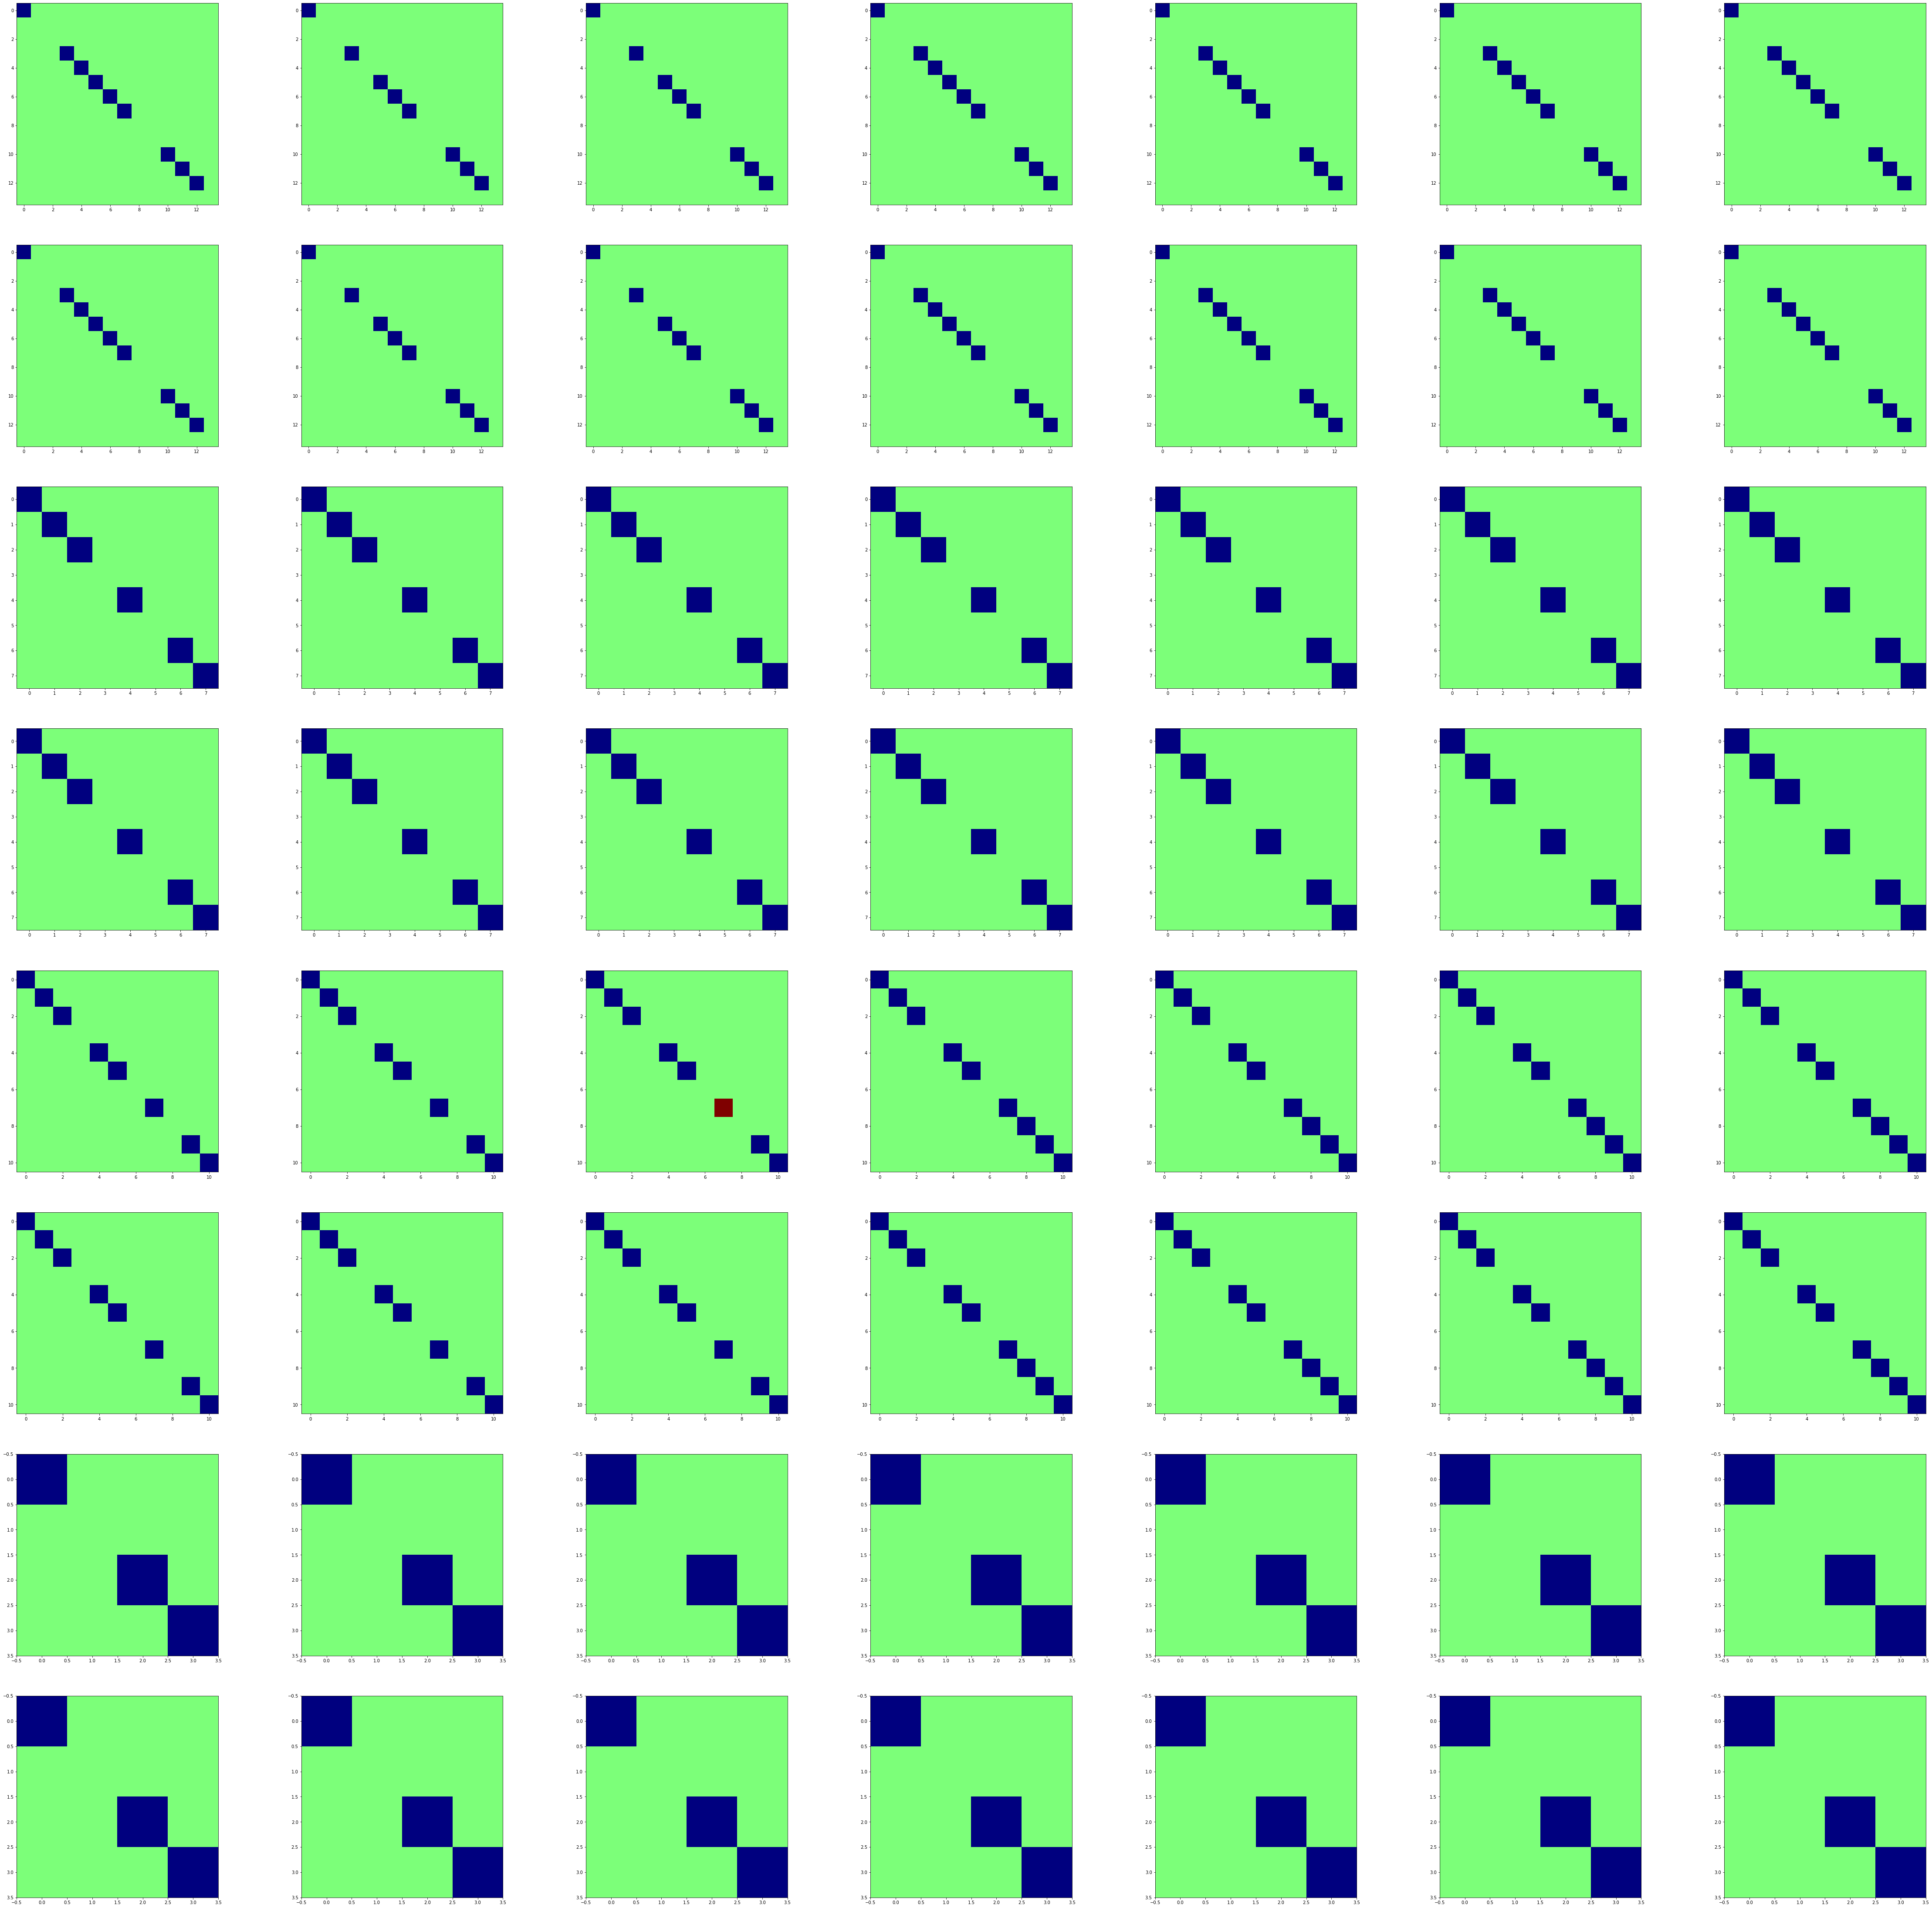

In [20]:
from matplotlib import pyplot as plt

it = val_data.as_numpy_iterator()
x_temp, y_temp = it.next()

temp_adj = y_temp['temporal_adj_matrices']

output = tm.training_model.predict(x_temp)

fig, axes = plt.subplots(8,7,figsize=(80,80))

for j in range(4):
    for i in range(7):
        pred = output[j, i, ...]
        truth = temp_adj[j, i, ...]

        summed = np.sum(truth, axis=-1)
        bad_loc = np.where(summed == -3)[1]
        end = bad_loc[0] - 1
        summed = np.sum(truth, axis=-1)

        axes[2 * j,i].imshow(np.argmax(pred[0:end, 0:end, :], axis=-1), cmap='jet', vmin=0, vmax=2)
        axes[2 * j + 1, i].imshow(np.argmax(truth[0:end, 0:end, :]==1, axis=-1), cmap='jet', vmin=0, vmax=2)

## Save the Model

In [21]:
# Save models for prediction
inf_path = os.path.join(MODEL_DIR, 'TrackingModelInf')
ne_path = os.path.join(MODEL_DIR, 'TrackingModelNE')

tm.inference_model.save(inf_path)
tm.neighborhood_encoder.save(ne_path)

INFO:tensorflow:Assets written to: /data/models/TrackingModelInf/assets


INFO:tensorflow:Assets written to: /data/models/TrackingModelInf/assets


INFO:tensorflow:Assets written to: /data/models/TrackingModelNE/assets


INFO:tensorflow:Assets written to: /data/models/TrackingModelNE/assets


## Next Steps

This model is used within an assignment problem framework to track cells through time-lapse sequences and build cell lineages. To see how this works on example data, see below. 

To use existing models for tracking (and segmentation), refer to its counterpart in the `deepcell.application` [notebook series](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Nuclear-Application.ipynb).

## Load the Model and Track One Movie

In [22]:
# Instantiate Models
from deepcell.model_zoo.tracking import GNNTrackingModel
tm = GNNTrackingModel()

# Load models for prediction
# (update `ne_path` and `inf_path` if different from above)
tm.neighborhood_encoder = tf.keras.models.load_model(ne_path)
tm.inference_model = tf.keras.models.load_model(inf_path)

Load a segmented movie from `deepcell.datasets` to track

In [23]:
# Choose and load a dataset to track using the trained model
benchmark_filename = 'HEK293_benchmarks.trks'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracked.hek293_bench.load_tracked_data(benchmark_filename)
print('HEK293 -\nX.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

path_bench_trks = os.path.join(DATA_DIR, benchmark_filename)
test_data = load_trks(path_bench_trks)

raw_images = test_data['X'][1]
labeled_movie = test_data['y'][1]

HEK293 -
X.shape: (20, 30, 135, 160, 1)
y.shape: (20, 30, 135, 160, 1)


### Import the cell tracking algorithm and track the movie

In [24]:
from deepcell_tracking import CellTracker

cell_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    track_length=track_length,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model)

In [25]:
%%time

cell_tracker.track_cells()

CPU times: user 4.15 s, sys: 160 ms, total: 4.31 s
Wall time: 3.75 s


### Review the results

In [26]:
# View tracked results of each batch as a video
# NB: This does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(raw_images, axis=0),
                  batch=0, cmap='gray'))

In [27]:
# Tracked

# Scale the colors to match the max cell label
HTML(get_js_video(np.expand_dims(cell_tracker.y_tracked, axis=0),
                  batch=0, cmap='cubehelix', vmin=0,
                  vmax=len(cell_tracker.tracks)))

# Save the Output

If desired, save the results in our compressed format (.trk - with lineage information), as a movie (.gif - images only/no lineage information), or both

In [28]:
# Save trk file
res_file_path = os.path.join(OUTPUT_DIR, 'hek_test.trk')
cell_tracker.dump(res_file_path)

In [33]:
# Save stacks
import imageio

# TODO: this should get removed from the notebook and added to `deepcell.utils.io_utils`
# TODO: any reason to save the intermediate tiff files?

vmax = len(cell_tracker.y_tracked)

raw = []
tracked = []

for i in range(cell_tracker.X.shape[0]):
    new_image = cell_tracker.X[i, ..., 0]
    raw_path = os.path.join(OUTPUT_DIR, 'image_%d.tiff' % i)
    imageio.imwrite(raw_path, new_image)
    raw.append(new_image)

    label_image = cell_tracker.y_tracked[i, ..., 0]
    label_path = os.path.join(OUTPUT_DIR, 'label_%d.tiff' % i)
    plt.imsave(label_path, label_image.astype('uint8'), cmap='cubehelix', vmin=0, vmax=vmax)
    # imageio.imwrite(label_path, label_image.astype('uint8'), cmap='cubehelix', vmin=0, vmax=vmax)
    tracked.append(label_image)

# Make gifs
imageio.mimsave('/raw.gif', raw)
imageio.mimsave('/tracked.gif', tracked)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

Lossy conversion from int32 to uint8. Range [0, 122]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 122]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 123]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 128]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 128]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 

# Benchmark the Results

N.B. Requires the result to be saved to .trk file

In [31]:
# First, we'll need the ground truth to compare against 
# So we select and save a .trk from our set of tracks (.trks)
gt_trk_path = os.path.join(OUTPUT_DIR, 'hek_test_gt.trk')

gt_trk = {
    'X': test_data['X'][1],
    'y_tracked': test_data['y'][1],
    'tracks': test_data['lineages'][1]
}

# TODO: The following is a work around to save .trk file using CellTracker .dump method
gt_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model
)
gt_tracker.dump(filename=gt_trk_path, track_review_dict=gt_trk)

In [33]:
import json

res_trk_path = res_file_path
# (update `gt_trk_path` if different from above)

from deepcell_tracking.isbi_utils import benchmark_division_performance

results = benchmark_division_performance(gt_trk_path, res_trk_path)
print(json.dumps(results, indent=4))

5_9 out degree = 1, daughters mismatch.
missed node 21_21 division completely
{
    "Correct division": 1,
    "Incorrect division": 1,
    "False positive division": 1,
    "False negative division": 1
}
